### **LAB 2 -** Computer Vision. Convolutional Neural Networks.
Group: M25-RO-01

Instructor: Alexey Kornaev

TA: Kirill Yakovlev

**INTRODUCTION AND THEORETICAL BACKGROUND**

Today we start talking about one of the most important and fundamental concept in Computer Vision - **convolutions.**

Let's start from fundamental understanding: **each kind of information usually has its own properties, which means theres exists specific methods to deal with that.** Without digging too deep in to the concept of data and information, let's assume that today's AI world is dealing with the following  types of data:
- text
- audio
- images and video
- tabular data
- mixed type of data

To distinguish them properly we focus on different characteristics, e.g. by defining what is **the unit of information** of each data type. In that sense, for text it could a token, for images - a pixel, whereas for videos it's a bit more complex, as we might consider not only pixels, but frames as well. Definitely each data type has its own inherent properties that methods are trying to deal with. On this course we will be mainly tied with an image data world (and a bit with videos as well) as well as on methods to process that.

What is the main idea that stands behind convoltion creation? Well, the answer is not that sophisticated - **we want to extract or make something useful (e.g. transformation) to solve some tasks and problems.** From the perspective of ML, extracting something useful to make our model more efficient in solving our initial task (classification, generation, segmentation, etc.)

In that sense we can consider images as matrices with **ordered set of pixels**, where each of them has a corresponding value of intensity in each color channel, which can be also considered as a separate matrix (fr, fg, fb).
So we want to extract features from images or matrix-like type of data.


<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/RGB_channels_separation.png" width="350" height="300">

A pixel intensity usually exists in interval between 0 and 255 in each color channel. Such structure makes it possible to represent a numerous number of colors, where:

- black corresponds to a vector of zeros - [0,0,0]
- white is represented as [255, 255, 255]

The image itself can be represented as H x W x C, where H is a height of image or number of pixel vectors in matrix, W - width or number of pixels in each vector, C - number of channels or number of pixel matrices.

Remember that RGB is not the single format we can use to represent image data, but it is straight and understandable for a human perception. Additionally you can read about other color formats, especially take an attention to a **LAB** representation.

https://opencv.org/blog/color-spaces-in-opencv/

BUT: how do we use such information inside our images? Well, at first sight we can just squeeze our image into a row vector and apply some classical methods like Multi-Layer Perceptron, but such "trivial" has some problems:

- each pixel will be processed by a separate parameter that enormously increase number of parameters and make our solution completely **indigestible** for high-dimensional cases

- we lose **"spatial" information** of the image

But what does that mean? Let's take a look on a simple set of images:

<img src="https://yastatic.net/s3/education-portal/media/puppy_a1d259493d_708f608dce.webp" width="100" height="100">

<img src="https://yastatic.net/s3/education-portal/media/shifted_puppy_c27db8708f_ca16064a3b.webp" width="100" height="100">

<img src="https://yastatic.net/s3/education-portal/media/scaled_puppy_d6c7abac44_a80f12b60e.webp" width="100" height="100">

<img src="https://yastatic.net/s3/education-portal/media/flipped_puppy_a8a6029dce_c8300e6bd9.webp" width="100" height="100">

What have you noticed? Despite we have the same dog on each image, it can be differently located or might be changed in some simple way (mirrored, croped, etc.). Is it still a problem for the MLP? **NO**, because of [universal approximation theorem](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/). But it makes our solution TOO complex.

So definitely we cannot ignore those potential cases, but methods should be **invariant** to such tranformations and a with reasonable computational complexity.

This is where **Linear Shift-Invariant System** (LSIS) comes to the play. Such systems have **two** fundamental properties:

1. **Linearity** - System follows a superposition principle

if $f_{1}(t)$ produces response $g_{1}(t)$ and $f_{2}(t)$ produces response
$g_{2}(t)$, then any linear combination $a*f_{1}(t)$ + $b*f_{2}(t)$ will produce the response $a*g_{1}(t)$ + $b*g_{2}(t)$, where a and b are constants. IOW, a linear map or linear function f(x) is a function that satisfies the two properties:

- Additivity: f(x + y) = f(x) + f(y)
- Homogeneity: f(αx) = α f(x) for all α


2. **Shift-Invariance** - A shift-invariant system is one where a shift in the independent variable of the input signal causes a corresponding shift in the output signal. So simply if we shift the input in time then the output is shifted by the same amount.

f(x(t)) = y(t), shift invariance means that f(x(t + a)) = y(t + a)

<img src="https://i.postimg.cc/63L3Nt3G/LSIS.png" width="300" height="300">

Simple is that.



Ok let's switch to convolutions itlself. We will not dive very deeply about convolution's structure and why it is as it is, as many things have appeared through time and methodical evolution.

**Convolution** is nothing else but a mathematical operation of integration of convolving one function through the other.

<img src="https://i.postimg.cc/Nj3J3wZH/Convolution.png" width="750" height="200">

Practically we turn to convolution filters that exist as kernels that sit on top of the image and slides from left to right and up to down, applying a mathematical operation at each (x, y) - coordinate in the original image.
Kernel is just a small (usually) $N x N$ matrix. It allows to structurally transform each pixel of an image.

Let's take a look on the example.


<img src="https://i.postimg.cc/3RXZ0HPD/2D-Convolution-Animation.gif" width="250" height="200">

<img src="https://i.postimg.cc/nzNCxsdn/matrix.png" width="550" height="250">


The area of ​​the image that our neural network “looks” at is called the **receptive field** (yellow zone), and we often have to think about it in computer vision problems.

Finally, linearity of convolutions provide the following properties:

1. Commutative → a * b = b * a
2. Associative → (a * b) * c = a * (b * c)

How does it help us?
If we are doing series of convolutions, then we can simplify our system

$f → conv1 → conv2→ g ⇔ f → conv1 * conv2→ g ⇔ f → conv2* conv1→ g$

Ok, simply this is the basics that stands behind convolution. All other concepts like **padding**, **activation maps**, **pooling**, etc. is better absorbed during practices. Let's switch to the practical part...

**Let's take a simple classification case for a better understading using a pytorch framework.**

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

**Let's start with sequential transformations. Do you know what they are exactly doing?**

In [2]:
transform_cifar_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip an image horizontally (left to right) with a specified probability
    transforms.RandomCrop(32, padding=4), # taking a random NxN pixel crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalizes an image tensor by mapping its pixel values from a [0, 1] range to a [-1, 1] range
])

transform_cifar_test = transform_cifar_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Uploading data and finalizing dataset preparation

cifar10_train = datasets.CIFAR10(root='data', train=True, transform=transform_cifar_train, download=True)
cifar10_test = datasets.CIFAR10(root='data', train=False, transform=transform_cifar_test, download=True)

cifar10_loader_train = DataLoader(cifar10_train, batch_size=32, shuffle=True)
cifar10_loader_test = DataLoader(cifar10_test, batch_size=32)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


**Let's start with designing our first architecture. We want to keep it as simple as possible in the first attempt gradually improving it in next sections. This CNN consists of one convolutional layer following by the max pooling layer and finalizing our model by the fully connected layer for the classification purpose.**

In [3]:
class My_First_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 16 * 16, 10)
        self.out = nn.LogSoftmax(dim=1)
        # self.out = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv(x))) # why do we need ReLU here?
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc(x)
        x = self.out(x)
        return x

**Let's take a look on our model!**

In [4]:
model = My_First_CNN()
print(model)

My_First_CNN(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
  (out): LogSoftmax(dim=1)
)


**Also we can check our model out and analyze its properties using summary. Sometimes it also can help you arrange size of your layers and avoid training errors.**

In [5]:
from torchsummary import summary

model = My_First_CNN()
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Linear-3                   [-1, 10]          40,970
        LogSoftmax-4                   [-1, 10]               0
Total params: 41,418
Trainable params: 41,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.16
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


**Next let's try to train our initial model and see what result we will get. Let's make a specific function for that so we can reuse it for further experiments.**

In [6]:
def train(model, train_loader, test_loader, optimizer, criterion = torch.nn.NLLLoss(),
          n_epochs = 10, max_epochs_stop = 3, save_file = 'model-cifar.pt'):

    # specify loss function
    criterion = criterion

    # specify optimizer
    optimizer = optimizer

    epochs_no_improve = 0
    max_epochs_stop = max_epochs_stop
    test_loss_min = np.inf

    for epoch in range(1, n_epochs+1):

        # keep track of training and Test loss
        train_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        test_acc = 0



        # TRAIN STEP


        model.train()

        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # Calculate accuracy (don't forget to modify if you are using Cross-Enthropy and Softmax function)
            ps = torch.exp(output) # why we need exp?
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end = '\r')

        # VALIDATION STEP


        model.eval()
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average Test loss
            test_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            test_acc += accuracy.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_acc = train_acc/len(train_loader)
        test_acc = test_acc/len(test_loader)

        # print training/Test statistics
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, train_loss, test_loss))
        print(f'Training Accuracy: {100 * train_acc:.2f}%\t Test Accuracy: {100 * test_acc:.2f}%')

        # save model if Test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            test_loss_min,
            test_loss))
            torch.save(model.state_dict(), save_file)
            epochs_no_improve = 0
            test_loss_min = test_loss
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early Stopping')
                break

**Let's specify our training parameters like number of training epochs, optimzier, etc. It's up to you what you think can be specified to enhance your results**

In [7]:
n_epochs = 20 # you may increase this number to train in a final model
optimizer = optim.Adam(model.parameters()) # Choosing optimizer. Let's choose classical Adam optimizer
save_file_name = 'model-cifar.pt' # define name to save weights of our model

**Last step we can specify whether we want to train our model by CPU or GPU. In colab you can choose T4 in your Runtime type settings, but usage time is a strictly limited.**

In [8]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

**Start training...**

In [9]:
train(model, cifar10_loader_train, cifar10_loader_test, optimizer = optimizer,
      n_epochs = n_epochs, save_file = save_file_name)


Epoch: 1 	Training Loss: 1.428883 	Test Loss: 1.231967
Training Accuracy: 49.81%	 Test Accuracy: 56.11%
Test loss decreased (inf --> 1.231967).  Saving model ...

Epoch: 2 	Training Loss: 1.186587 	Test Loss: 1.170744
Training Accuracy: 58.64%	 Test Accuracy: 59.71%
Test loss decreased (1.231967 --> 1.170744).  Saving model ...

Epoch: 3 	Training Loss: 1.100484 	Test Loss: 1.142016
Training Accuracy: 61.99%	 Test Accuracy: 60.62%
Test loss decreased (1.170744 --> 1.142016).  Saving model ...

Epoch: 4 	Training Loss: 1.038417 	Test Loss: 1.149749
Training Accuracy: 64.08%	 Test Accuracy: 60.15%
1 epochs with no improvement.

Epoch: 5 	Training Loss: 0.987043 	Test Loss: 1.099203
Training Accuracy: 65.81%	 Test Accuracy: 62.31%
Test loss decreased (1.142016 --> 1.099203).  Saving model ...

Epoch: 6 	Training Loss: 0.946673 	Test Loss: 1.080561
Training Accuracy: 67.47%	 Test Accuracy: 62.42%
Test loss decreased (1.099203 --> 1.080561).  Saving model ...

Epoch: 7 	Training Loss: 0.91

**By such trivial architecture we are still able to achieve accuracy >62% which is pretty decent given number of classes.**

**But let's switch to something more advanced like DNN (Deep Neural Networks). Basically, it means we start stacking many layers sequentially making our model more complex as well as increasing it is ability to catch more advanced relations between training data and classes accordingly. BTW, what happens with a receptive field by stacking more convolution layers?**

**TO make it more convenient pytorch has a special method [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) making it easier to construct more complex architectures. However, it requires some different reorganization in code from us. We can arrange this architecture as blocks for feature extraction and classification procedures.**

In [10]:
class CNN_advanced(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        self.classification_block = nn.Sequential(
            nn.Linear(in_features= 4 * 4 * 4 * 4, out_features=10),
        )
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feature_extraction_block(x)
        x = self.flatten(x)
        x = self.classification_block(x)
        x = self.out(x)
        return x

In [11]:
model = CNN_advanced()
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 16, 8, 8]           4,624
              ReLU-8             [-1, 16, 8, 8]               0
         MaxPool2d-9             [-1, 16, 4, 4]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
       LogSoftmax-12                   [-1, 10]               0
Total params: 12,282
Trainable params: 12,282
Non-trainable params: 0
---------------------------------

**We can notice that adding new convolution layers is not associated with significant parameter increase, which is crucial when you are dealing with calculation resource limitations.**

**Let's try to train our new model...**

**Don't hesitate to repeat training process couple (several) times, remember that we are dealing with a LOCALLY optimal parametric system that sometimes is associated with unstable results.**

In [12]:
n_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=1e-3)
save_file_name = 'model-cifar-advanced.pt'

train(model, cifar10_loader_train, cifar10_loader_test, optimizer = optimizer,
      n_epochs = n_epochs, save_file = save_file_name)


Epoch: 1 	Training Loss: 1.547406 	Test Loss: 1.347166
Training Accuracy: 43.64%	 Test Accuracy: 51.67%
Test loss decreased (inf --> 1.347166).  Saving model ...

Epoch: 2 	Training Loss: 1.264989 	Test Loss: 1.190085
Training Accuracy: 55.00%	 Test Accuracy: 57.38%
Test loss decreased (1.347166 --> 1.190085).  Saving model ...

Epoch: 3 	Training Loss: 1.144745 	Test Loss: 1.099198
Training Accuracy: 59.65%	 Test Accuracy: 61.15%
Test loss decreased (1.190085 --> 1.099198).  Saving model ...

Epoch: 4 	Training Loss: 1.063494 	Test Loss: 1.032497
Training Accuracy: 62.66%	 Test Accuracy: 63.61%
Test loss decreased (1.099198 --> 1.032497).  Saving model ...

Epoch: 5 	Training Loss: 1.008829 	Test Loss: 1.037454
Training Accuracy: 64.57%	 Test Accuracy: 63.75%
1 epochs with no improvement.

Epoch: 6 	Training Loss: 0.967562 	Test Loss: 1.007779
Training Accuracy: 66.01%	 Test Accuracy: 64.59%
Test loss decreased (1.032497 --> 1.007779).  Saving model ...

Epoch: 7 	Training Loss: 0.92

**As we can notice adding couple new convolution layers gave us ~4.9% increase in accuracy, which is not that bad.**

**This principle with a consequent applying convolution with ReLU and max pooling can be met in advanced deep architectures like VGG16 (image below). But for CIFAR10 this architecture looks exorbitantly advanced.**

![](https://www.researchgate.net/profile/Jose-Cano-6/publication/327070011/figure/fig1/AS:660549306159105@1534498635256/VGG-16-neural-network-architecture.png)

**Nevertheless, for real-world problems when we usually stick to already existent solutions and architectures. Pytorch provides already pretrained models for classification tasks usually pretrained on [Image Net](https://www.image-net.org/) dataset. As of today they have the following models available:**



* AlexNet
* ConvNeXt
* DenseNet - Dense connections to improve gradient flow and feature reuse
* EfficientNet - Compound scaling method to scale, depth, width and resolution
* EfficientNetV2
* GoogLeNet
* Inception V3 - Inception modules with convolutional filters of different sizes
* MaxVit
* MNASNet
* MobileNet V2
* MobileNet V3
* RegNet
* ResNet - Residual Blocks
* ResNeXt
* ShuffleNet V2
* SqueezeNet
* SwinTransformer
* VGG - Deep Networks of 16 or 19 layers, convolutions 3x3
* VisionTransformer
* Wide ResNets

**Let's take something pretty straightforward from the architectural perspective. For example DenseNet looks appropriate for demonstrative goals. You can apply two different strategies:**

1.   pretrained=**True**: use the pre-trained weights of the model which are trained on a larger database (recommended)
2.   pretrained=**False**: begin with randomized weights and the densenet121 architecture.

**Let's upload a model with pretraiend weights and check its architectural shape.**

In [13]:
model = models.densenet121(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 159MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**As the next step we can define some transformations step for our data before training our architectrue. It is up to you which transformations you think seems relevant.**

In [14]:
transform_cifar_train_densenet = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_cifar_test_densenet = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [15]:
cifar10_train_pre = datasets.CIFAR10(root='data', train=True, transform=transform_cifar_train_densenet, download=True)
cifar10_test_pre = datasets.CIFAR10(root='data', train=False, transform=transform_cifar_test_densenet, download=True)

cifar10_loader_train_pre = DataLoader(cifar10_train_pre, batch_size=32, shuffle=True)
cifar10_loader_test_pre = DataLoader(cifar10_test_pre, batch_size=32)

**Given we want to base our solution on some pretrained architecture we are not interested to retrain already existed layers in this model.**

**First let's check whether layers are in "training" mode.**

In [16]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

features.conv0.weight True
features.norm0.weight True
features.norm0.bias True
features.denseblock1.denselayer1.norm1.weight True
features.denseblock1.denselayer1.norm1.bias True
features.denseblock1.denselayer1.conv1.weight True
features.denseblock1.denselayer1.norm2.weight True
features.denseblock1.denselayer1.norm2.bias True
features.denseblock1.denselayer1.conv2.weight True
features.denseblock1.denselayer2.norm1.weight True
features.denseblock1.denselayer2.norm1.bias True
features.denseblock1.denselayer2.conv1.weight True
features.denseblock1.denselayer2.norm2.weight True
features.denseblock1.denselayer2.norm2.bias True
features.denseblock1.denselayer2.conv2.weight True
features.denseblock1.denselayer3.norm1.weight True
features.denseblock1.denselayer3.norm1.bias True
features.denseblock1.denselayer3.conv1.weight True
features.denseblock1.denselayer3.norm2.weight True
features.denseblock1.denselayer3.norm2.bias True
features.denseblock1.denselayer3.conv2.weight True
features.denseb

**Next let's change this by applying False mode for each layer in the pretrained model. Since we know that classifier layer is responsible specifically for distinguising classes we can replace it by some new parametric module. For this purpose we can also apply Sequential method from the previous section.**

In [17]:
for param in model.parameters():
    param.requires_grad = False

**Let's take a layer for retraining...**

In [18]:
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

In [19]:
num_features = model.classifier.in_features

In [20]:
model.classifier = nn.Sequential(
                        nn.Linear(num_features, 256),
                        nn.LeakyReLU(),
                        nn.Dropout(0.3),
                        nn.Linear(256, 10),
                        nn.LogSoftmax(dim=1))

                        # nn.Softmax(dim=1))

In [21]:
n_epochs = 40
optimizer = optim.Adam(model.parameters(), lr=1e-4)
save_file_name = 'model-cifar-pretrained.pt'

train(model, cifar10_loader_train_pre, cifar10_loader_test_pre, optimizer = optimizer,
      n_epochs = n_epochs, criterion = torch.nn.NLLLoss(), max_epochs_stop = 5, save_file = save_file_name)


Epoch: 1 	Training Loss: 1.383521 	Test Loss: 1.067161
Training Accuracy: 51.75%	 Test Accuracy: 63.21%
Test loss decreased (inf --> 1.067161).  Saving model ...

Epoch: 2 	Training Loss: 1.069990 	Test Loss: 0.992979
Training Accuracy: 62.60%	 Test Accuracy: 65.96%
Test loss decreased (1.067161 --> 0.992979).  Saving model ...

Epoch: 3 	Training Loss: 0.973434 	Test Loss: 0.972500
Training Accuracy: 65.93%	 Test Accuracy: 66.62%
Test loss decreased (0.992979 --> 0.972500).  Saving model ...

Epoch: 4 	Training Loss: 0.892809 	Test Loss: 0.960244
Training Accuracy: 68.72%	 Test Accuracy: 66.93%
Test loss decreased (0.972500 --> 0.960244).  Saving model ...

Epoch: 5 	Training Loss: 0.838915 	Test Loss: 0.977106
Training Accuracy: 70.60%	 Test Accuracy: 67.76%
1 epochs with no improvement.

Epoch: 6 	Training Loss: 0.784997 	Test Loss: 0.959945
Training Accuracy: 72.52%	 Test Accuracy: 67.85%
Test loss decreased (0.960244 --> 0.959945).  Saving model ...

Epoch: 7 	Training Loss: 0.74

**AS we might notice result is not that drastically better compared to our initial model with convolution layers. Still you can try some new models as well as new a new shape for a classifier module.**

**That's it for today...**

---

## **Home Task**

You can choose any multi-label classification dataset for the following task.


1.   In this task you need to take a Fashion MNIST dataset and achieve **>85%** accuracy. You are able to improve the initial architecture using unused methods and tricks to improve the final result (max pooling, dropout, etc.). BUT do not make your model too complex (max 4 densed layers excluding convoltion and softmax layers).

2.  Explain what methods (or model additions) have had the biggest impact on the test set accuracy. Provide graphical comparison in metrics between models of different architectures.

3.  Train an additional architecture using any pretrained model to achieve comparable accuracy of **~85%** or higher. Try to beat a result obtained in the 1st task.

Requirements:

*   You should have your own classification layer (usually the last one) or layer that is responsible for classification. You can add a new layer if a classification layer is initially absent
*   You are able to choose at least one layer to retrain from the pretrained architecture
*   Architecture should beat the initial model in the 1st task
*   You  can choose any architecture from the pretrained list of [PyTorch](https://https://docs.pytorch.org/vision/main/models.html)




Remember that you have approximately **7 days** to complete these tasks. You are allowed to use any avaialble computational resource.

**Expected result:** uploaded Jupyter notebook with completed tasks to the Moodle assignment section.

In [24]:
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]


Text(0.5, 1.0, 'Image label: 5')

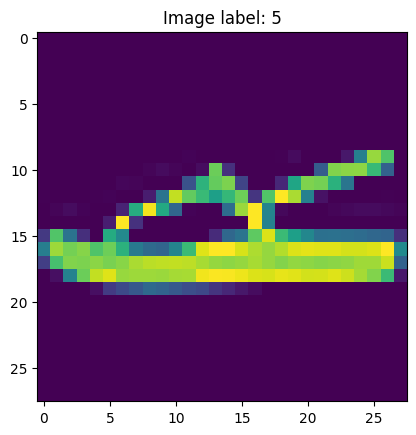

In [25]:
train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

In [ ]:
# *** YOUR CODE ***